In [1]:
%pylab inline
from gpkit import *

Populating the interactive namespace from numpy and matplotlib


In [73]:
Ndeep = 6
Nwide = 6

class Flow(Model):
    """
    Variables
    ---------
    T             [K]         temperature
    rho    1.2    [kg/m^3]    density
    mu     1.4e-5 [Pa*s]      viscosity
    v             [m/s]       characteristic velocity
    
    Upper Unbounded
    ---------------
    T, v

    Lower Unbounded
    ---------------
    T, v
    """
    def setup(self):
        exec parse_variables(Flow.__doc__)

class RectFlowArea(Model):
    """
    Variables
    ---------
    l             [m]         characteristic length
    Re            [-]         Reynolds number
    height   0.02 [m]         channel height
    width    0.02 [m]         channel width
    A             [m^2]       area
    mdot          [kg/s]      mass flow
    
    Upper Unbounded
    ---------------
    v, T

    Lower Unbounded
    ---------------
    v, T
    """
    def setup(self):
        exec parse_variables(RectFlowArea.__doc__)
        flow = self.flow = Flow()
        v = self.v = flow.v
        self.T = flow.T
        return [
            self.flow,
            mdot == flow.rho*A*v,
            A == height*width,
            l == A**0.5,
            Re == l*v*flow.rho/flow.mu
        ]
        

class FlowVolume(Model):
    """
    Variables
    ---------
    T            [K]        geometric mean of input and ouput temperatures
    width        [m]        geometric mean of characteristic lengths
    L       0.02 [m]        distance between FlowAreas
    delT         [K]        difference in temperature
    c       1    [J/kg/K]   heat capacity
    Q            [W]        heat loss
    
    Upper Unbounded
    ---------------
    mdot, hiTT

    Lower Unbounded
    ---------------
    Q, loTT
    """
    def setup(self, loT=None, hiT=None):
        exec parse_variables(FlowVolume.__doc__)
        hiT = self.hiT = hiT or RectFlowArea()
        loT = self.loT = loT or RectFlowArea()
        
        self.loTT = loT.T
        self.hiTT = hiT.T
        
        mdot = self.mdot = loT.mdot
        self.height = loT.height
        
        return [
            self.hiT, self.loT,
            hiT.mdot == loT.mdot,
            T == (hiT.T*loT.T)**0.5,
            width == (hiT.width*loT.width)**0.5,
            hiT.T >= loT.T + delT,
            Q <= delT*mdot*c
        ]
    
class Pipe(Model):
    """
    Upper Unbounded
    ---------------
    mdot, hiTT

    Lower Unbounded
    ---------------
    Qi, loTT
    """
    def setup(self, N, loT=None, hiT=None, flowlo2hi=True):
        flowvols = self.flowvols = []
        self.loT = loT
        self.hiT = hiT
        order = range(N) if flowlo2hi else range(N-1,-1,-1)
        for i in order:
            lo, hi = None, None
            if i == 0 and loT:
                lo = loT
            if flowlo2hi and i > 0:
                lo = flowvols[-1].hiT
            if i == N-1 and hiT:
                hi = hiT
            if not flowlo2hi and i < N-1:
                hi = flowvols[-1].loT
            flowvols.append(FlowVolume(loT=lo, hiT=hi))
        self.Qi = self.flowvols[0].Q
        self.mdot = self.flowvols[0].mdot
        if flowlo2hi:
            self.loTT = flowvols[0].loT.T
            self.hiTT = flowvols[-1].hiT.T
        else:
            self.hiTT = flowvols[0].hiT.T
            self.loTT = flowvols[-1].loT.T
        return [
            self.flowvols,
            [self.Qi == fv.Q for fv in flowvols[1:]]
        ]
        
class HeatExchanger(Model):
    """
    Variables
    ---------
    h        10 [W/K/m^2]   convection coefficient
    height    5 [m]         height of cell

    Lower Unbounded
    ---------------
    Qi
    
    """
    def setup(self, Nliq, Nair):
        exec parse_variables(HeatExchanger.__doc__)
        
        liqin = self.liqin = RectFlowArea()
        with Vectorize(Nliq):
            liqpipes = self.liqpipes = Pipe(Nair, hiT=liqin, flowlo2hi=False)
        liqpipes.substitutions.update({liqin.T: 500, liqin.v: 10})
        
        airin = self.airin = RectFlowArea()
        with Vectorize(Nair):
            airpipes = self.airpipes = Pipe(Nliq, loT=airin)
        airpipes.substitutions.update({airin.T: 303, airin.v: 20})
        
        self.Qi = liqpipes.Qi[0]
        Qeq = [liqpipes.Qi == self.Qi, airpipes.Qi == self.Qi]
        
        self.hx = []
        for i in range(Nliq):
            for j in range(Nair):
#                 delT = liqpipes.flowvols[j].T[i] - airpipes.flowvols[i].T[j]
                C = h*liqpipes.flowvols[j].width[i]*airpipes.flowvols[i].width[j]
                self.hx.append([
                    self.Qi + airpipes.flowvols[i].T[j]*C <= liqpipes.flowvols[j].T[i]*C
                ])
        return [
            airpipes, liqpipes,
            Qeq, self.hx,
        ]
        
HX = HeatExchanger(2, 2)
HX.cost = 1/HX.Qi
sol = HX.solve()

Using solver 'mosek'
Solving for 88 variables.
Solving took 0.0165 seconds.


In [60]:
for i in range(5):
    print sol(HX.liqpipes.flowvols[i].T)

[ 483.76470237  484.68883543  485.6003097   486.50927754  487.46190778] kelvin
[ 451.67517534  454.42461451  457.14245834  459.85616491  462.69171847] kelvin
[ 419.25027101  423.91192589  428.52823101  433.13798661  437.92057795] kelvin
[ 386.17094967  392.92132677  399.61761343  406.29910911  413.14831418] kelvin
[ 348.12221217  358.18142036  368.2162407   378.25013355  388.37471206] kelvin


In [67]:
for i in range(5):
    print sol(HX.airpipes.flowvols[i].T)

[ 314.52600833  313.28125238  311.98441904  310.62895399  309.12846676] kelvin
[ 338.64354993  334.6433184   330.50323332  326.20648115  321.51174157] kelvin
[ 364.34514198  357.14402919  349.73752666  342.10251056  333.89483995] kelvin
[ 392.79923965  381.63725611  370.23477272  358.56626344  346.27778051] kelvin
[ 434.57623617  415.98510287  397.19916411  378.17407649  358.6605789 ] kelvin


In [10]:
Ndeep = 2
Nwide = 2

Tinf = Variable("Tinf", 303, "K")
Tin = Variable("Tin", "K")
Tout = Variable("Tout", "K")
clq = Variable("clq", 1, "J/K/kg")
Toutair = Variable("Toutair", "K")
Vinf = Variable("Vinf", 20, "m/s")

with Vectorize(Ndeep):
    mdotlq = Variable("mdotlq", "kg/s")
    with Vectorize(Nwide):
        Tlq = Variable("Tlq", "K")
        Tair = Variable("Tair", "K")
        Vlq = Variable("Vlq", "m/s")
        Vair = Variable("Vair", "m/s")
        Alq = Variable("Alq", "m^2")
        Aair = Variable("Aair", "m^2")
        
with Vectorize(Nwide):
    mdotair = Variable("mdotair", "kg/s")

constraints = [
    Tlq[0, :] == Tin,
    Tlq[-1, :] == Tout,
    Tair[:, 0] == Tinf,
    Vair[:, 0] == Vinf,
    [Vair[:,j] * Aair[:,j] == mdotair[j] for j in range(Nwide)],  # TODO: add compressibility?
    [Vlq[i,:] * Alq[i,:] == mdotlq[i] for i in range(Ndeep)],
    [Vair[i-1,:] >= Vair[i,:] + skinfriction[i,:]
     for i in range(1, Ndeep)],
    
    Tout >= Tin + delTlq,
    mdotlq == Vlq*Alq*rholq,
    Q <= delTlq*mdotlq.sum()*clq,  # TODO: bin by heatloss?
    
    Toutair >= Tinf + delTair,
    mdotair == Vair*Aair*rhoair,
    Q <= delTair*mdotair.sum()*cair,
]


NameError: name 'skinfriction' is not defined

In [57]:
from gpkit import Model, parse_variables, Vectorize, SignomialsEnabled
from heatexchanger.fluids import Air, Water
from heatexchanger.hxarea import HXArea


class RectangularPipe(Model):
    """
    Variables
    ---------
    mdot     [kg/s]   mass flow rate
    w        [m]      pipe width
    h        [m]      pipe height
    A        [m^2]    pipe area
    T_in     [K]      input temperature
    v_in     [m/s]    input velocity

    Variables of length Nsegments+1
    -------------------------------
    v        [m/s]    fluid velocity
    T        [K]      fluid temperature

    Variables of length Nsegments
    -----------------------------
    dT       [K]      Change in fluid temperature over segment
    dQ       [W]      Magnitude of heat transfer over segment

    Upper Unbounded
    ---------------
    w, h, mdot, T_out (if increasingT)

    Lower Unbounded
    ---------------
    dQ, T_out (if not increasingT)

    """
    def setup(self, Nsegments, fluid, increasingT):
        exec parse_variables(RectangularPipe.__doc__)
        self.increasingT = increasingT
        self.T_out = T[-1]
        self.fluid = fluid
        if increasingT:
            temp = T[1:] >= T[:-1] + dT
        else:
            temp = T[:-1] >= T[1:] + dT
        return [
            fluid, temp,
            T[0] == T_in, v[0] == v_in,
            mdot == fluid.rho*v*A,
            A == w*h,
            dQ <= mdot*fluid.c*dT,
        ]


class Layer(Model):
    """
    Variables
    ---------
    Q          [W]       heat transferred from air to liquid
    w          [m]       width
    d          [m]       depth
    h          [m]       height
    V        1 [cm^3]    volume
    h_liq      [m]       height of liquid layer
    h_air      [m]       height of air layer

    Lower Unbounded
    ---------------
    Q

    """
    def setup(self, Nairpipes, Nwaterpipes):
        exec parse_variables(Layer.__doc__)
        self.Nairpipes = Nairpipes
        self.Nwaterpipes = Nwaterpipes
        
        air = Air()
        with Vectorize(Nairpipes):
            airpipes = RectangularPipe(Nwaterpipes, air, increasingT=True,
                                       substitutions={"T_in": 303,
                                                      "v_in": 20})
            self.airpipes = airpipes
        water = Water()
        with Vectorize(Nwaterpipes):
            waterpipes = RectangularPipe(Nairpipes, water, increasingT=False,
                                         substitutions={"T_in": 500,
                                                        "v_in": 5})
            self.waterpipes = waterpipes
        with Vectorize(Nwaterpipes):
            with Vectorize(Nairpipes):
                c = self.c = HXArea()

        with SignomialsEnabled():
            # unfortunately this appears unavoidable.
            # perhaps an entropy-based approach could get around it?
            # as the mass flows in each pipe become quite similar,
            # it's already alllllmost GP, solving in 3-9 GP solves
            SP_Qsum = Q <= c.dQ.sum()

        return [
            # SIZING
            V >= d*w*h,
            h >= h_liq + h_air,
            waterpipes,
            d >= waterpipes.w.sum(),
            h_liq == waterpipes.h,
            airpipes,
            w >= airpipes.w.sum(),
            h_air == airpipes.h,

            # CONSERVATION OF HEAT
            SP_Qsum,
            c.dQ == waterpipes.dQ,
            c.dQ == airpipes.dQ.T,   # airpipes are rotated 90deg

            # HEAT EXCHANGE
            c, c.A_hx == airpipes.w.outer(waterpipes.w),
            c.T_hot == waterpipes.T[1:],  # Tcell = Tout (conservative)
            c.T_cld == airpipes.T[1:].T,  # airpipes are rotated 90deg
        ]


if __name__ == "__main__":
    m = Layer(30, 20)
    m.cost = 1/m.Q
    sol = m.localsolve()
    print sol(m.Q)

Beginning signomial solve.
Solving took 3 GP solves and 10.7 seconds.
0.910325146197 watt


In [15]:
from matplotlib.pyplot import *
%matplotlib inline

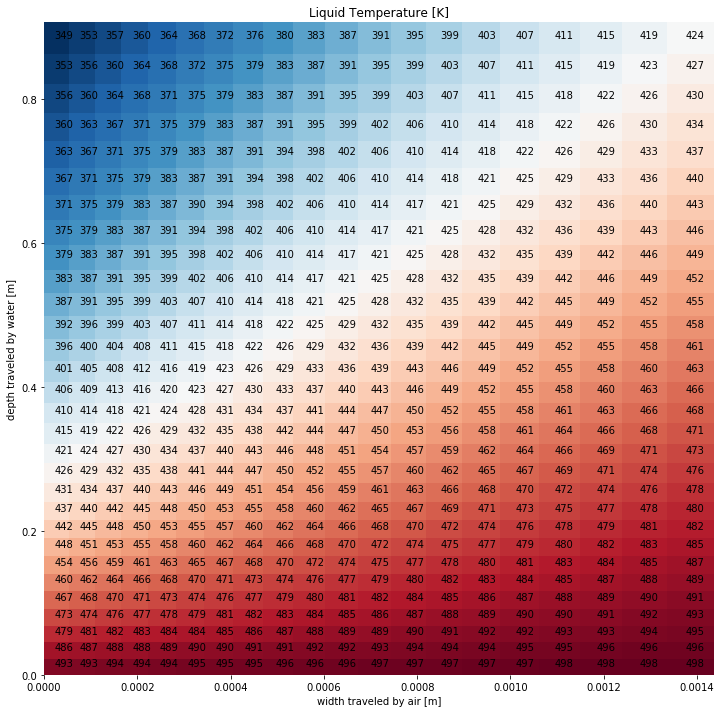

In [65]:
def plot_cells(m, Z, cm=cm.RdBu_r, verbosity=0):
    f, a = subplots(figsize=(12,12))
    sol = m.solution
    Zmin, Zmax = Z.min(), Z.max()
    dpos = 0
    for i in range(m.Nwaterpipes):
        wpos = 0
        for j in range(m.Nairpipes):
            wcell = sol(m.airpipes.w)[j].magnitude
            dcell = sol(m.waterpipes.w)[i].magnitude
            z = ((Z[j,i] - Zmin)/(Zmax-Zmin)).magnitude
            r = Rectangle((dpos,wpos), dcell, wcell, facecolor=cm(z))
            if verbosity:
                labelx, labely = dpos, wpos + wcell/2
                label = "%.3g" % Z[j,i].magnitude
                if verbosity > 1:
                    label = "[%i,%i] : "%(i,j) + label
                else:
                    labelx += 0.4*dcell
                a.text(labelx, labely, label)
            wpos += wcell
            a.add_patch(r)
        dpos += dcell
    ylim([0, wpos])
    xlim([0, dpos])
    a.set_frame_on(False)
    a.set_xlabel("width traveled by air [m]")
    a.set_ylabel("depth traveled by water [m]")
    return f, a

f, a = plot_cells(m, sol(m.waterpipes.T)[1:], verbosity=1)
_ = a.set_title("Liquid Temperature [K]")

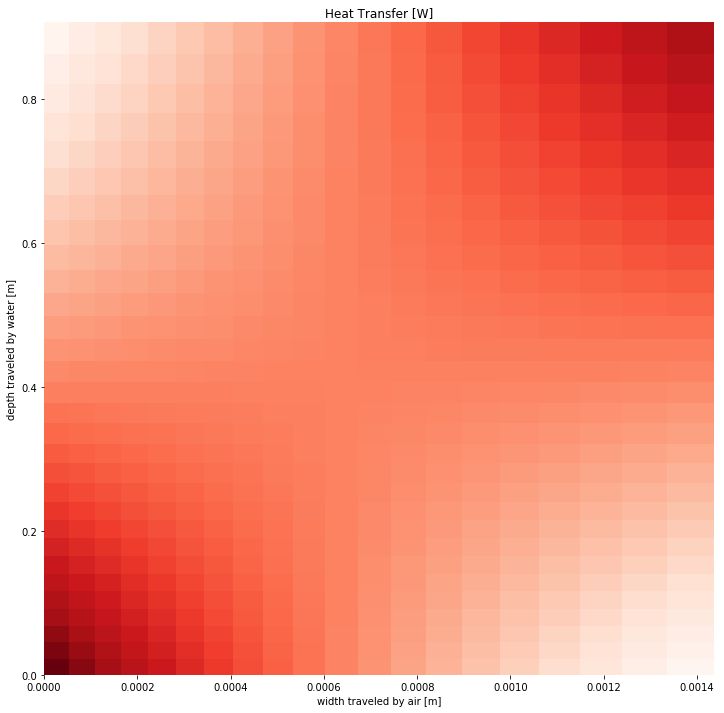

In [67]:
f, a = plot_cells(m, sol(m.c.dQ), cm=cm.Reds)
_ = a.set_title("Heat Transfer [W]")

In [15]:
Ndeep = 6
Nwide = 6

Qtot2 = Variable("Qtot2", "W")
Tinf = Variable("Tinf", 303, "K")
Tin = Variable("Tin", 500, "K")
Tout = Variable("Tout", "K")
mdotlqtot = Variable("mdotlqtot", "kg/s")
clq = Variable("clq", 3, "J/K/kg")
cair = Variable("cair", 1, "J/K/kg")
Vinf = Variable("Vinf", 20, "m/s")
Vlqinf = Variable("Vlqinf", 5, "m/s")
rholq = Variable("rholq", 1e3, "kg/m^3")
rhoair = Variable("rhoair", 1.2, "kg/m^3")
width = Variable("width", "m")
depth = Variable("depth", "m")
V = Variable("V", 1, "cm^3")

with Vectorize(Nwide):
    with Vectorize(Ndeep):
        Tlq = Variable("Tlq", "K")
        Tair = Variable("Tair", "K")
        Vlq = Variable("Vlq", "m/s")
        Vair = Variable("Vair", "m/s")
        widthair = Variable("widthair", "cm")
        depthlq = Variable("depthlq", "cm")
        
with Vectorize(Ndeep-1):
    mdotair = Variable("mdotair", "kg/s")
with Vectorize(Nwide-1):
    mdotlq = Variable("mdotlq", "kg/s")
    
heightlq = Variable("heightlq", "cm")
heightair = Variable("heightair", "cm")

with Vectorize(Nwide-1):
    with Vectorize(Ndeep-1):
        delTlq = Variable("delTlq", "K")
        delTair = Variable("delTair", "K")
        h = Variable("h", 10, "W/K/m^2")
        Tlqcell = Variable("Tlqcell", "K")
        Taircell = Variable("Taircell", "K")
        wcell = Variable("wcell", "cm")
        dcell = Variable("dcell", "cm")
        Qair = Variable("Qair", "W")
        Qlq = Variable("Qlq", "W")
        Qhx = Variable("Qhx", "W")
        Q = Variable("Q", "W")

with SignomialsEnabled():
    constraints = [
        # maximize Q
        [Q[:,j-1] <= mdotlq[j-1]*clq*delTlq[:,j-1] for j in range(1, Nwide)],
        [Q[i-1,:] <= mdotair[i-1]*cair*delTair[i-1,:] for i in range(1, Ndeep)],
        
        [depth >= depthlq[i,1:].sum() for i in range(Ndeep)],
        [width >= widthair[1:,j].sum() for j in range(Nwide)],
        
        V >= width*depth*(heightlq + heightair),
        
#         [Tlqcell[i-1,j-1] == (Tlq[i,j])*Tlq[i-1,j])**0.5
#          for i in range(1, Ndeep) for j in range(1, Nwide)],
#         [Taircell[i-1,j-1] == (Tair[i,j])*Tair[i,j-1])**0.5
#          for i in range(1, Ndeep) for j in range(1, Nwide)],
        
        [wcell[i-1,j-1] == (depthlq[i,j]*depthlq[i-1,j])**0.5
         for i in range(1, Ndeep) for j in range(1, Nwide)],
        [dcell[i-1,j-1] == (widthair[i,j]*widthair[i,j-1])**0.5
         for i in range(1, Ndeep) for j in range(1, Nwide)],
        
        Q <= (Tlq[1:,1:]-Tair[1:,1:])*h*wcell*dcell,
        
        mdotlqtot <= mdotlq.sum(),
        
        Qtot2 <= (Tin-Tout)*mdotlqtot*clq,
        Qtot <= Q.sum(),

        [mdotlq[j-1] == Vlq[:,j]*depthlq[:,j]*heightlq*rholq for j in range(1,Nwide)],
        [mdotair[i-1] == Vair[i,:]*widthair[i,:]*heightair*rhoair for i in range(1,Ndeep)],

        [Tlq[i-1,1:] >= Tlq[i,1:] + delTlq[i-1,:] for i in range(1,Ndeep)],
        [Tair[1:,j] >= Tair[1:,j-1] + delTair[:,j-1] for j in range(1,Nwide)],
        
        # boundary conditions
        Tlq[0, 1:] == Tin,
        Tout >= (Tlq[-1, 1:]*mdotlq).sum()/mdotlqtot,
        Tair[1:, 0] == Tinf,
        Vair[1:, 0] == Vinf,
        Vlq[0, 1:] == Vlqinf,
    ]
m = Model(1/Qtot * 1/Qtot2**0.0001, constraints)
sol = m.localsolve()

Beginning signomial solve.
Solving took 38 GP solves and 3.38 seconds.


In [6]:
Ndeep = 6
Nwide = 6

Qtot2 = Variable("Qtot2", "W")
Tinf = Variable("Tinf", 303, "K")
Tin = Variable("Tin", 500, "K")
Tout = Variable("Tout", "K")
clq = Variable("clq", 3, "J/K/kg")
cair = Variable("cair", 1, "J/K/kg")
Vinf = Variable("Vinf", 20, "m/s")
Vlqinf = Variable("Vlqinf", 5, "m/s")
rholq = Variable("rholq", 1e3, "kg/m^3")
rhoair = Variable("rhoair", 1.2, "kg/m^3")
width = Variable("width", "m")
depth = Variable("depth", "m")
V = Variable("V", 1, "cm^3")

with Vectorize(Nwide):
    with Vectorize(Ndeep):
        Tlq = Variable("Tlq", "K")
        Tair = Variable("Tair", "K")
        Vlq = Variable("Vlq", "m/s")
        Vair = Variable("Vair", "m/s")
        widthair = Variable("widthair", "cm")
        depthlq = Variable("depthlq", "cm")
        
with Vectorize(Ndeep-1):
    mdotair = Variable("mdotair", "kg/s")
with Vectorize(Nwide-1):
    mdotlq = Variable("mdotlq", "kg/s")
    
heightlq = Variable("heightlq", "cm")
heightair = Variable("heightair", "cm")

with Vectorize(Nwide-1):
    with Vectorize(Ndeep-1):
        delTlq = Variable("delTlq", "K")
        delTair = Variable("delTair", "K")
        h = Variable("h", 10, "W/K/m^2")
        Tlqcell = Variable("Tlqcell", "K")
        Taircell = Variable("Taircell", "K")
        wcell = Variable("wcell", "cm")
        dcell = Variable("dcell", "cm")
        Qair = Variable("Qair", "W")
        Qlq = Variable("Qlq", "W")
        Qhx = Variable("Qhx", "W")
        Q = Variable("Q", "W")
        
mdotlqeach = Variable("mdotlqeach", 10, "kg/s")

with SignomialsEnabled():
    constraints = [
        # maximize Q
        [Q[:,j-1] == mdotlq[j-1]*clq*delTlq[:,j-1] for j in range(1, Nwide)],
        [Q[i-1,:] == mdotair[i-1]*cair*delTair[i-1,:] for i in range(1, Ndeep)],
        
        [depth >= depthlq[i,1:].sum() for i in range(Ndeep)],
        [width >= widthair[1:,j].sum() for j in range(Nwide)],
        
        V >= width*depth*(heightlq + heightair),
        
        [wcell[i-1,j-1] == (depthlq[i,j]*depthlq[i-1,j])**0.5
         for i in range(1, Ndeep) for j in range(1, Nwide)],
        [dcell[i-1,j-1] == (widthair[i,j]*widthair[i,j-1])**0.5
         for i in range(1, Ndeep) for j in range(1, Nwide)],
        
        Q <= (Tlq[1:,1:]-Tair[1:,1:])*h*wcell*dcell,
        Q >= units("pW"),

        [mdotlq[j-1] == Vlq[:,j]*depthlq[:,j]*heightlq*rholq for j in range(1,Nwide)],
        [mdotair[i-1] == Vair[i,:]*widthair[i,:]*heightair*rhoair for i in range(1,Ndeep)],

        [Tlq[i-1,1:] >= Tlq[i,1:] + delTlq[i-1,:] for i in range(1,Ndeep)],
        [Tair[1:,j] >= Tair[1:,j-1] + delTair[:,j-1] for j in range(1,Nwide)],
        
        # boundary conditions
        Tlq[0, 1:] == Tin,
        Tair[1:, 0] == Tinf,
        Vair[1:, 0] <= Vinf,
        Vlq[0, 1:] <= Vlqinf,
    ]
m = Model((Tlq[-1, 1:]*mdotlq).sum(), constraints)
sol = m.solve()

Using solver 'mosek'
Solving for 319 variables.
Solving took 0.0365 seconds.


In [46]:
print sol(Tlq[-1,1:])
print sol(mdotlq)
print sol(Tout)

[369 [K], 381 [K], 393 [K], 404 [K], 415 [K], 425 [K]]
[mdotlq_(0,) [kg/s], mdotlq_(1,) [kg/s], mdotlq_(2,) [kg/s], mdotlq_(3,) [kg/s], mdotlq_(4,) [kg/s], mdotlq_(5,) [kg/s]]
400.017206846 kelvin


In [962]:
print sol(Qtot)
print sol(Qtot2)
print sol(Q).sum()
print sol(Tout)

1.0 watt
1.0 watt
2.5e-11 watt
1.0 kelvin


In [965]:
print sol(heightlq), sol(heightair)
print sol(width), sol(depth)

0.0499750611771 centimeter 0.0499750611771 centimeter
0.000153212796154 meter 4.99294952957 meter


In [54]:
sol(Tlq)

<Quantity([[          nan  500.          500.          500.          500.          500.
   500.        ]
 [          nan  471.74255884  476.01809299  479.85722059  483.27502981
   486.282875    488.8904068 ]
 [          nan  446.21189044  453.6742462   460.48840154  466.66203212
   472.19540158  477.08439612]
 [          nan  423.28645771  432.96696375  441.96282213  450.26203638
   457.84104371  464.66772635]
 [          nan  402.876421    413.92337361  424.3785318   434.20639019
   443.35510292  451.75847549]
 [          nan  384.914261    396.59524185  407.86335915  418.66230723
   428.91424049  438.51983858]
 [          nan  369.34264336  381.05124324  392.57200762  403.83504387
   414.74375141  425.17222011]], 'kelvin')>

AttributeError: 'NomialArray' object has no attribute 'magnitude'

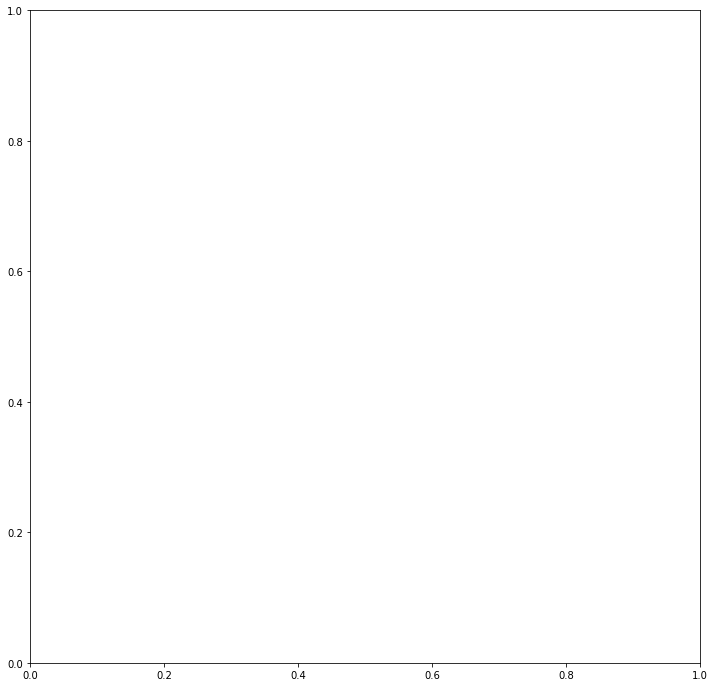

In [45]:
def plot_cells(Z, cm=cm.RdBu_r):
    f, a = subplots(figsize=(12,12))
    dpos = 0
    for i in range(Ndeep-1,0,-1):
        wpos = 0
        for j in range(1,Nwide):
            wcell = sol(widthair[i,j]).magnitude
            dcell = sol(depthlq[i,j]).magnitude
            doff = sol(depthlq).magnitude[i,1:].max()-dcell
            z = ((Z[i-1,j-1] - Z.min())/(Z.max()-Z.min())).magnitude
            r = Rectangle((wpos,dpos+doff), wcell, dcell, facecolor=cm(z))
    #         a.text(wpos, dpos, "%i,%i : %i"%(i,j,Z[i-1,j-1].magnitude))
            wpos += sol(widthair).magnitude[1:,j].max()
            a.add_patch(r)
        dpos += sol(depthlq).magnitude[i,1:].max()
    ylim([0, dpos])
    xlim([0, wpos])
    a.set_frame_on(False)
    a.set_xticks([])
    a.set_yticks([])
    return f, a

f, a = plot_cells(sol(Tlq)[1:,1:])
_ = a.set_title("Liquid Temperature")

In [992]:
sol(Tlq)[1:,1:]

<Quantity([[ 466.66038898  471.58504935  476.01401393  479.96143882  483.43847505
   486.45581931]
 [ 437.36886255  445.69607515  453.335354    460.28576045  466.53985134
   472.08760013]
 [ 411.90882615  422.34143555  432.11197116  441.19179424  449.5410785
   457.11285563]
 [ 390.10183048  401.56489844  412.532936    422.94944492  432.74094023
   441.8198994 ]
 [ 371.7756851   383.42076214  394.81134146  405.8710599   416.50027791
   426.57686854]], 'kelvin')>

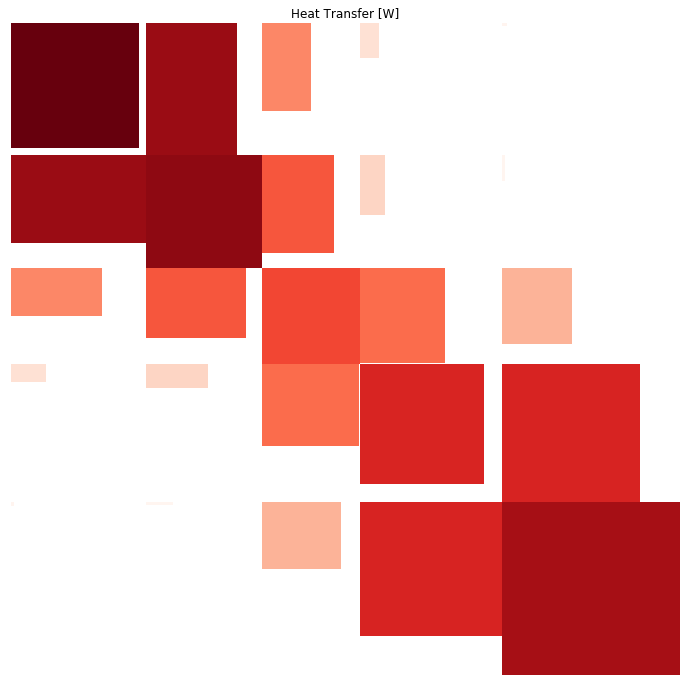

In [17]:
f, a = plot_cells(sol(Q), cm=cm.Reds)
_ = a.set_title("Heat Transfer [W]")